# Solar ANN 

### Load and preprocess data

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

data = pd.read_csv('/Users/dltc2020/Documents/Senior-project/combined_fuel_weather_data.csv')
data = data.fillna(0)
data['BeginDate'] = pd.to_datetime(data['BeginDate']).dt.tz_localize(None)
data["Sum"] = data[["Coal", "Hydro", "Natural Gas", "Nuclear", "Oil", "Other", "Landfill Gas", "Refuse", "Solar", "Wind", "Wood"]].sum(axis=1)
data['Previous_Day'] = data['BeginDate'] - pd.Timedelta(days=1)
data['Previous_Year'] = data['BeginDate'] - pd.DateOffset(years=1)
solar_data = data[['BeginDate', 'Solar','Previous_Day','Previous_Year']].copy()


/var/folders/lp/l5v0z5894r912dc6qp90m2j00000gn/T/ipykernel_4750/1002017534.py:6: DtypeWarning: Columns (12,17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/Users/dltc2020/Documents/Senior-project/combined_fuel_weather_data.csv')


In [22]:
def get_previous_day_Solar(row, reference_df):
    # Find the Wind value closest to the 'Previous_Day'
    closest_entry = reference_df.iloc[(reference_df['BeginDate'] - row['Previous_Day']).abs().argsort()[:1]]
    if not closest_entry.empty:
        return closest_entry['Solar'].values[0]
    return None

In [23]:
def get_previous_year_Solar(row, reference_df):
    # Find the Wind value closest to the 'Previous_Day'
    closest_entry = reference_df.iloc[(reference_df['BeginDate'] - row['Previous_Year']).abs().argsort()[:1]]
    if not closest_entry.empty:
        return closest_entry['Solar'].values[0]
    return None

In [26]:

data['Previous_Year_Solar'] = data.apply(get_previous_day_Solar, axis=1, reference_df=solar_data)

In [29]:
cutoff_date = pd.to_datetime("2023-10-01").tz_localize(None)
usable_data = data[data['BeginDate'] > cutoff_date].copy()
solar_data2 = usable_data[['BeginDate', 'Solar','Previous_Day','Previous_Year']].copy()

In [30]:


usable_data['Previous_Day_Solar'] = usable_data.apply(get_previous_day_Solar, axis=1, reference_df=solar_data2)


In [37]:
usable_data['Hour_of_Day'] = usable_data['BeginDate'].dt.hour
features = usable_data[['Sum','temp', 'humidity', 'precip',  'sealevelpressure', 'cloudcover', 'solarradiation','Previous_Day_Solar','solarenergy','Hour_of_Day','dew','windgust','windspeed']]

# Useless Features , 'winddir','Previous_Year_Solar',
target = usable_data['Solar']

print("Features shape: ", features.shape)
print('Target shape: ', target.shape)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

Features shape:  (92714, 13)
Target shape:  (92714,)


In [38]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32)

test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

Epoch 1/50


/usr/local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1855/1855 ━━━━━━━━━━━━━━━━━━━━ 3s 997us/step - loss: 18466.4297 - val_loss: 5775.0928
Epoch 2/50
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 2s 900us/step - loss: 5347.2471 - val_loss: 4731.8740
Epoch 3/50
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 2s 906us/step - loss: 4569.3765 - val_loss: 4275.8857
Epoch 4/50
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 2s 907us/step - loss: 4201.0586 - val_loss: 4013.3701
Epoch 5/50
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 2s 902us/step - loss: 3962.6750 - val_loss: 4183.9116
Epoch 6/50
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 2s 932us/step - loss: 3751.4678 - val_loss: 3881.7627
Epoch 7/50
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 2s 935us/step - loss: 3634.8350 - val_loss: 3566.1721
Epoch 8/50
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 2s 898us/step - loss: 3441.8911 - val_loss: 3404.4509
Epoch 9/50
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 2s 899us/step - loss: 3265.7505 - val_loss: 3321.5283
Epoch 10/50
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 2s 913us/step - loss: 3133.9561 - val_loss: 3204.5957
Epoch 11/50
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 2s 902

### Analysis

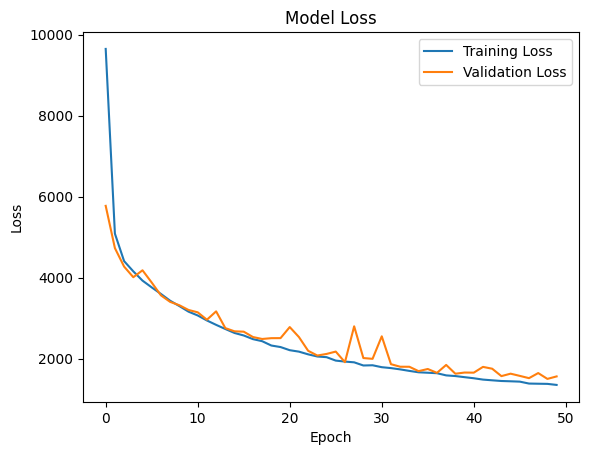

In [39]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Make predictions

In [50]:
import numpy as np
predictions = model.predict(X_test)
flattened_predictions = [0 if (isinstance(pred, np.ndarray) and pred.item() < 0) else (0 if pred < 0 else pred.item() if isinstance(pred, np.ndarray) else pred) for pred in predictions]

print(f'Predicted Solar Energy Ouput: {flattened_predictions[:20]}')
print(f'Actual Solar Energy Output: {y_test[:20].values}')


580/580 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step
Predicted Solar Energy Ouput: [0, 839.3920288085938, 424.1498718261719, 0.8506642580032349, 10.657052993774414, 524.439208984375, 0, 11.262176513671875, 554.1375732421875, 1.6239415407180786, 233.17161560058594, 2.494508743286133, 20.85013198852539, 2.267688751220703, 227.2106475830078, 79.51811981201172, 18.04292869567871, 7.91890811920166, 0.17582905292510986, 7.953271865844727]
Actual Solar Energy Output: [  7. 725. 313.  10.   3. 510.   0.   8. 545.   1. 212.   1.   4.   0.
  80.  34.  19.   0.   0.   0.]


In [53]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming predictions and y_test are numpy arrays or pandas series
# predictions = model.predict(X_test)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
average_y_test = np.mean(y_test)
percent_error = mae / average_y_test

# Display results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Percent Error (PERR): {percent_error}")

Mean Absolute Error (MAE): 23.307292168524725
Mean Squared Error (MSE): 1620.6476589864028
Root Mean Squared Error (RMSE): 40.25726839946301
Percent Error (PERR): 0.15879231891127168


### Save model

In [54]:
model.save('SolarModel.h5')